<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/006_TensorFlow_Proj_Six_FFNN_EmployeeDoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [1]:
# utils
import os, sys, pprint
import pandas as pd
import numpy as np
# google
from google.colab import drive
# tensorflow
import tensorflow as tf
from tensorflow import keras
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
# vis
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("tensorflow:", tf.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

tensorflow: 2.17.0
pandas: 2.1.4
numpy: 1.26.4


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
working_dir = '/content/drive/MyDrive/DataSets/employee'
# os.listdir(working_dir)
os.chdir(working_dir)
assert os.getcwd() == working_dir

## Libs

In [6]:
def reduce_memory_usage(df, category = False):
    start_mem = df.memory_usage().sum() / (1024**2)
    print("Memory usage of dataframe is {:2f} MB!".format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if category:
                df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / (1024**2)
    print("Memory usage after optimization is {:2f} MB!".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem-end_mem) / start_mem))

In [7]:
def display_df(df, message = " "):
    print("Dataframe: {}".format(message))
    num_rows = len(df)
    num_cols = len(df.columns)
    print("num_rows = {:,} \nnum_cols = {:,}".format(num_rows, num_cols))
    display(df.head())
    print("Info:")
    print(df.info())
    df_null = df.isnull().sum()
    if len(df_null)==0:
        print("Number of null data points:",df_null[df_null!=0])
    else:
        print("Number of null data points:")
        print(df_null[df_null!=0])

In [8]:
def summarize_columns(df):
    num_rows = len(df)
    summary = pd.DataFrame(df.dtypes, columns=["dtypes"])
    summary = summary.reset_index()
    summary["col_name"] = summary["index"]
    summary = summary[["col_name", "dtypes"]]
    summary["missing"] = df.isnull().sum().values
    summary["missing_percent"] = summary["missing"].apply(lambda x: round(x*1000/num_rows, 1))
    summary["uniques"] = df.nunique().values
    summary["first_value"] = df.iloc[0].values
    summary["second_value"] = df.iloc[1].values
    summary["third_value"] = df.iloc[2].values
    return summary

## Preprocess

In [11]:
dataset = pd.read_csv("employee.csv")

In [12]:
display_df(dataset, message = "dataset")

Dataframe: dataset
num_rows = 14,999 
num_cols = 10


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   department             14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
Number of null data points:
Series([], dtype: int64)


In [13]:
reduce_memory_usage(dataset, category = True)

Memory usage of dataframe is 1.144455 MB!
Memory usage after optimization is 0.186564 MB!
Decreased by 83.7%


In [14]:
categorical_columns = ['Work_accident','promotion_last_5years', 'department', 'salary']
dataset[categorical_columns] = dataset[categorical_columns].astype('category')

In [15]:
summarize_columns(dataset)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,satisfaction_level,float16,0,0.0,92,0.379883,0.799805,0.109985
1,last_evaluation,float16,0,0.0,65,0.529785,0.859863,0.879883
2,number_project,int8,0,0.0,6,2,5,7
3,average_montly_hours,int16,0,0.0,215,157,262,272
4,time_spend_company,int8,0,0.0,8,3,6,4
5,Work_accident,category,0,0.0,2,0,0,0
6,promotion_last_5years,category,0,0.0,2,0,0,0
7,department,category,0,0.0,10,sales,sales,sales
8,salary,category,0,0.0,3,low,medium,medium
9,left,int8,0,0.0,2,1,1,1


In [16]:
dataset['left'].value_counts()/len(dataset)

,count
left,
0,0.761917
1,0.238083


In [17]:
df = pd.get_dummies(dataset, drop_first=True)

In [18]:
display_df(df, message = "df")

Dataframe: df
num_rows = 14,999 
num_cols = 19


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,left,Work_accident_1,promotion_last_5years_1,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.379883,0.529785,2,157,3,1,False,False,False,False,False,False,False,False,True,False,False,True,False
1,0.799805,0.859863,5,262,6,1,False,False,False,False,False,False,False,False,True,False,False,False,True
2,0.109985,0.879883,7,272,4,1,False,False,False,False,False,False,False,False,True,False,False,False,True
3,0.720215,0.870117,5,223,5,1,False,False,False,False,False,False,False,False,True,False,False,True,False
4,0.370117,0.520020,2,159,3,1,False,False,False,False,False,False,False,False,True,False,False,True,False


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   satisfaction_level       14999 non-null  float16
 1   last_evaluation          14999 non-null  float16
 2   number_project           14999 non-null  int8   
 3   average_montly_hours     14999 non-null  int16  
 4   time_spend_company       14999 non-null  int8   
 5   left                     14999 non-null  int8   
 6   Work_accident_1          14999 non-null  bool   
 7   promotion_last_5years_1  14999 non-null  bool   
 8   department_RandD         14999 non-null  bool   
 9   department_accounting    14999 non-null  bool   
 10  department_hr            14999 non-null  bool   
 11  department_management    14999 non-null  bool   
 12  department_marketing     14999 non-null  bool   
 13  department_product_mng   14999 non-null  bool   
 14  department_sales

In [19]:
df.rename(columns=
          {
              "Work_accident_1": "work_accident",
              "promotion_last_5years_1": "promotion_last_five_years",
              "department_RandD": "department_r_and_d"
          },
          inplace=True)

In [20]:
X = df.drop("left", axis=1, inplace=False).values
y = df["left"].values
print(X.shape, y.shape)

(14999, 18) (14999,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500, shuffle=True, stratify=y)

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Sequential Model - Shallow

In [23]:
keras.backend.clear_session()
init_model = keras.Sequential(
    layers = [
      keras.layers.Input(shape=(X_train.shape[1],), name= "input_layer"),
      keras.layers.Dense(units=20, activation="relu", name= "dense_layer_one"),
      keras.layers.Dense(units=10, activation="relu", name= "dense_layer_two"),
      keras.layers.Dense(units=1, activation="sigmoid", name= "output_layer")
      ],
    name="init_model"
)
init_model.build(input_shape=(None, X_train.shape[1]))
init_model.summary()

Model: "init_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_layer_one (Dense)              │ (None, 20)                  │             380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_two (Dense)              │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 601 (2.35 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
init_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = init_model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=200, batch_size=128, callbacks=[callback])

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7353 - loss: 0.5707 - val_accuracy: 0.7538 - val_loss: 0.4735
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7813 - loss: 0.4342 - val_accuracy: 0.8150 - val_loss: 0.3911
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8537 - loss: 0.3582 - val_accuracy: 0.8633 - val_loss: 0.3307
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.3063 - val_accuracy: 0.8979 - val_loss: 0.2791
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9024 - loss: 0.2531 - val_accuracy: 0.9212 - val_loss: 0.2415
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9230 - loss: 0.2203 - val_accuracy: 0.9342 - val_loss: 0.2171
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9327 - loss: 0.1977 - val_accuracy: 0.9396 - val_loss: 0.1991
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9427 - loss: 0.1817 - val_accuracy: 0.9492 - v

In [26]:
init_model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9575 - loss: 0.1559


[0.15050466358661652, 0.9603333473205566]

In [27]:
model_preformance = pd.DataFrame(history.history)
model_preformance.tail()

,accuracy,loss,val_accuracy,val_loss
143,0.970205,0.084376,0.962917,0.140995
144,0.971872,0.083455,0.959583,0.143065
145,0.971664,0.083764,0.963750,0.140416
146,0.972080,0.083567,0.962917,0.141302
147,0.971976,0.083465,0.962917,0.141884


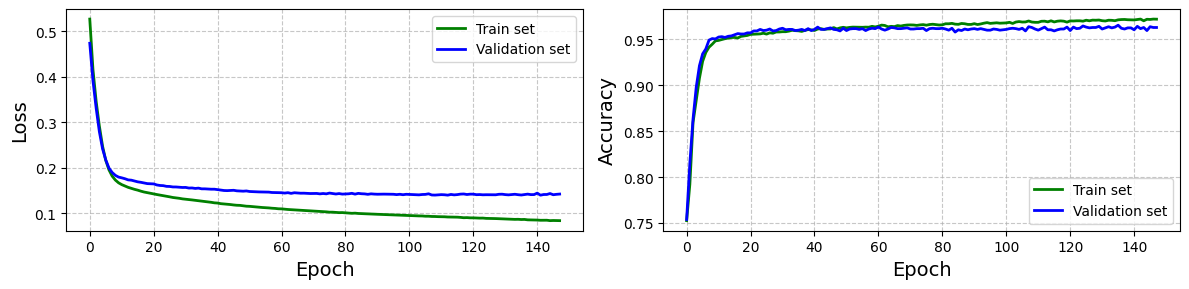

In [28]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(model_preformance["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# ax_one.set_facecolor('#f5f5f5')
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(model_preformance["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# ax_two.set_facecolor('#f5f5f5')
plt.tight_layout()

## Sequential Model - Deep

In [33]:
keras.backend.clear_session()
seq_model = keras.Sequential(name="seq_model")
seq_model.add(keras.layers.Input(shape=(X_train.shape[1],)))
seq_model.add(keras.layers.Dense(units=10, activation="relu", name="first_layer"))
seq_model.add(keras.layers.Dense(units=30, activation="relu", name="second_layer"))
seq_model.add(keras.layers.Dense(units=20, activation="relu", name="third_layer"))
seq_model.add(keras.layers.Dense(units=1, activation="sigmoid", name="output_layer"))
seq_model.build(input_shape=(None, X_train.shape[1]))
seq_model.summary()

Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ first_layer (Dense)                  │ (None, 10)                  │             190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Dense)                 │ (None, 30)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_layer (Dense)                  │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,161 (4.54 KB)

 Trainable params: 1,161 (4.54 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
seq_model.compile(optimizer="rmsprop", loss="binary_crossentropy",
                  metrics=[
                      tf.keras.metrics.Precision(),
                      keras.metrics.AUC(),
                      "accuracy",
                  ])

In [55]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = seq_model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=50, batch_size=128, callbacks=[callback])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9624 - auc: 0.9829 - loss: 0.1200 - precision_1: 0.9305 - val_accuracy: 0.9613 - val_auc: 0.9712 - val_loss: 0.1474 - val_precision_1: 0.9376
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9615 - auc: 0.9814 - loss: 0.1222 - precision_1: 0.9303 - val_accuracy: 0.9621 - val_auc: 0.9717 - val_loss: 0.1471 - val_precision_1: 0.9440
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9588 - auc: 0.9796 - loss: 0.1302 - precision_1: 0.9300 - val_accuracy: 0.9613 - val_auc: 0.9726 - val_loss: 0.1452 - val_precision_1: 0.9331
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9605 - auc: 0.9826 - loss: 0.1228 - precision_1: 0.9231 - val_accuracy: 0.9625 - val_auc: 0.9731 - val_loss: 0.1448 - val_precision_1: 0.9425
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9624 - auc: 0.9829 - loss: 0.1193 - precision_1: 0.9320 - val_accuracy: 0.9621 - val_auc: 0.9724 - val_loss: 0.

In [56]:
seq_model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9529 - auc: 0.9649 - loss: 0.1688 - precision_1: 0.8968


[0.14878225326538086,
 0.9204545617103577,
 0.9715099334716797,
 0.9593333601951599]

In [57]:
model_preformance = pd.DataFrame(history.history)
model_preformance.tail()

,accuracy,auc,loss,precision_1,val_accuracy,val_auc,val_loss,val_precision_1
45,0.968122,0.987943,0.098746,0.949793,0.966250,0.974075,0.143540,0.954306
46,0.968955,0.987953,0.098170,0.954567,0.965000,0.974553,0.143163,0.941581
47,0.968955,0.988047,0.098355,0.952469,0.964167,0.973869,0.142261,0.936860
48,0.968747,0.988042,0.097847,0.954103,0.964167,0.974385,0.141172,0.941379
49,0.968538,0.988234,0.096981,0.952800,0.964167,0.974727,0.140104,0.938356


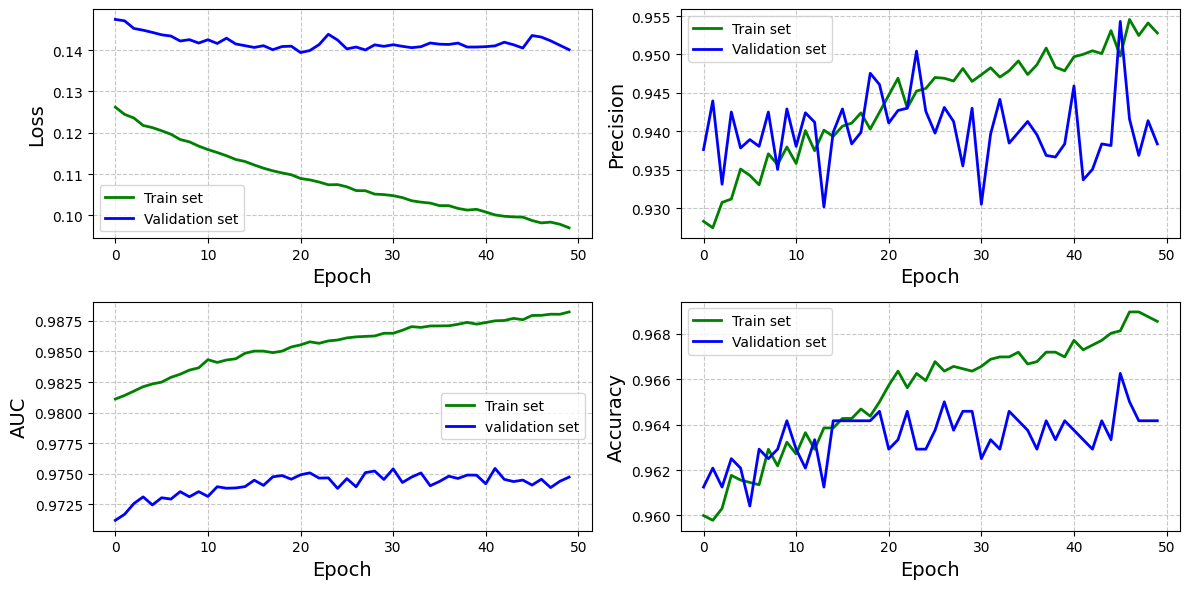

In [59]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(model_preformance["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.plot(model_preformance["precision_1"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_precision_1"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Precision", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.plot(model_preformance["auc"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_auc"], label= "validation set", color='b', linewidth=2)
plt.ylabel("AUC", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.plot(model_preformance["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [61]:
y_pred = np.rint(seq_model.predict(X_test))

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [62]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize=None)

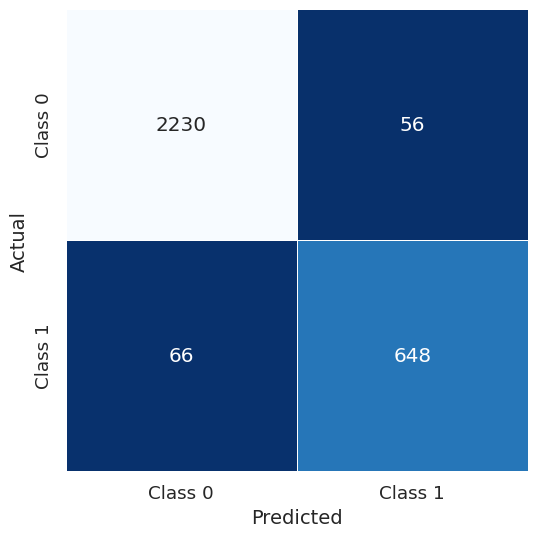

In [63]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='Blues_r', cbar=False, square=True,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

## Functional API

In [36]:
keras.backend.clear_session()
inputs = keras.Input(shape=(X_train.shape[1],), name="input_layer")
features = keras.layers.Dense(10, activation="relu", name="first_layer")(inputs)
features = keras.layers.Dropout(rate=0.2, name="first_drop_out")(features)
features = keras.layers.Dense(20, activation="relu", name="second_layer")(features)
features = keras.layers.Dense(5, activation="relu", name="third_layer")(features)
features = keras.layers.Dropout(rate=0.3, name="second_drop_out")(features)
outputs = keras.layers.Dense(1, activation="sigmoid", name="output_layer")(features)
func_model = keras.Model(inputs=inputs, outputs=outputs, name="func_model")
func_model.summary()

Model: "func_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (Dense)                  │ (None, 10)                  │             190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_drop_out (Dropout)             │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Dense)                 │ (None, 20)                  │             220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_layer (Dense)                  │ (None, 5)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_drop_out (Dropout)            │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

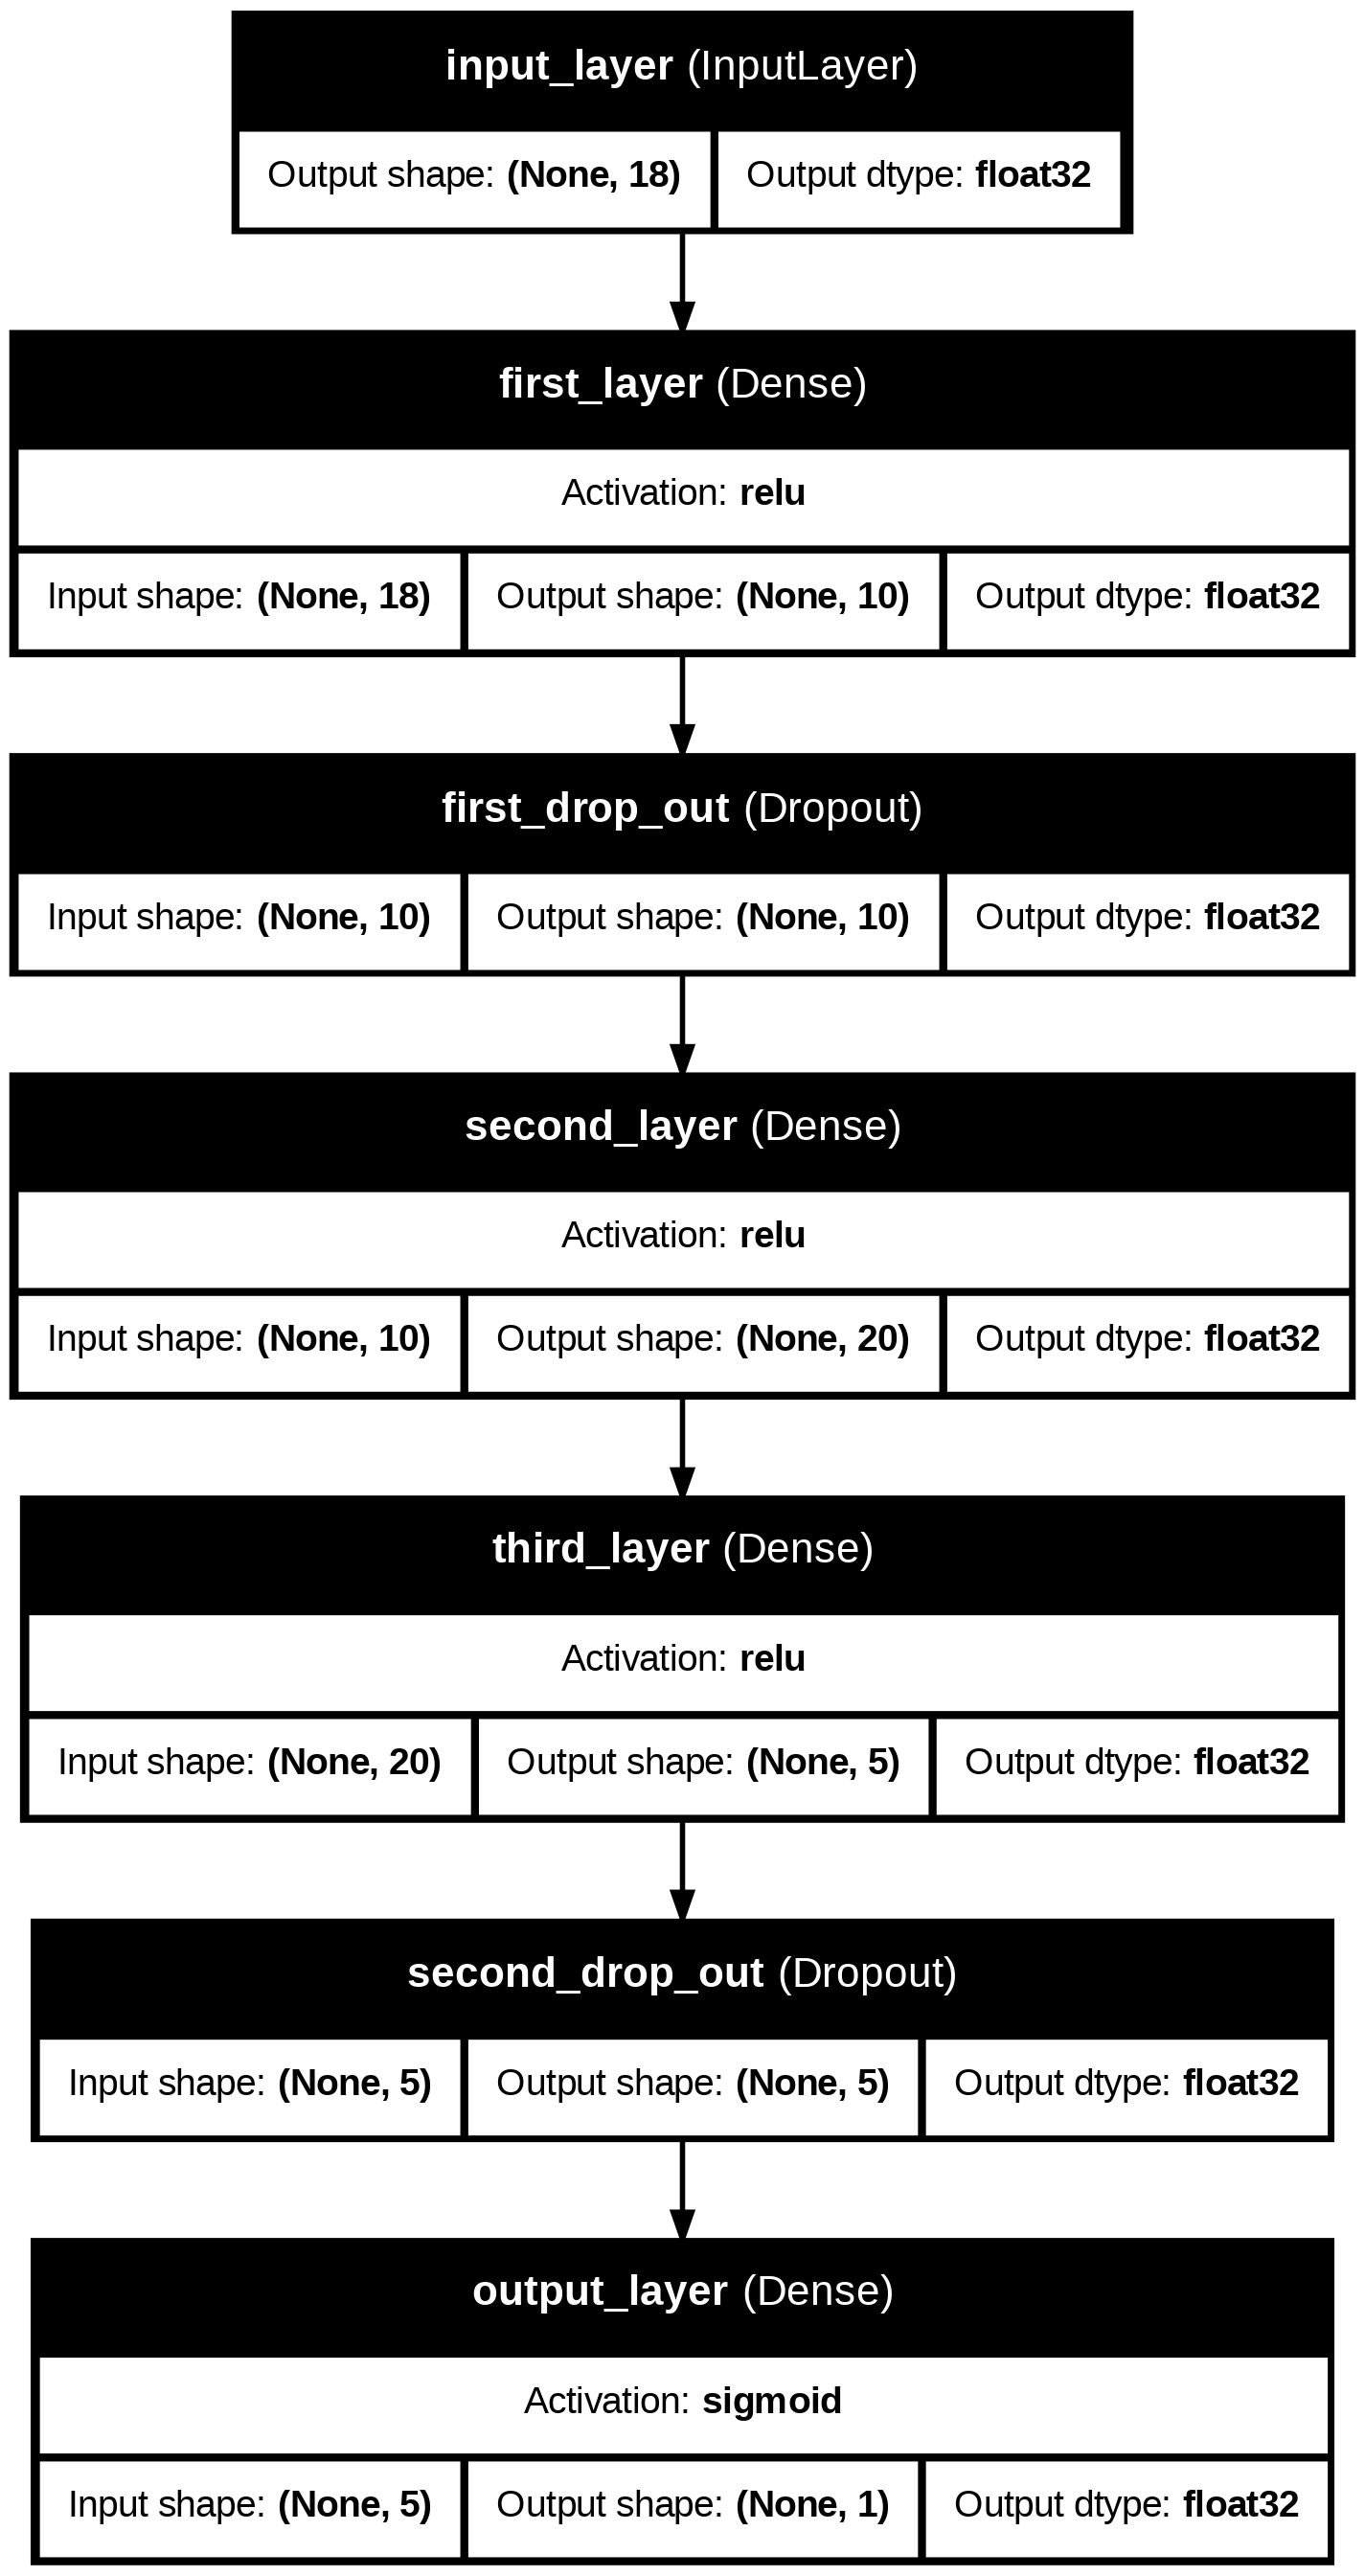

In [37]:
keras.utils.plot_model(func_model, "clf.png", show_dtype=True, show_layer_activations=True,
                       show_layer_names=True, show_shapes=True)

In [38]:
func_model.layers

[<InputLayer name=input_layer, built=True>,
 <Dense name=first_layer, built=True>,
 <Dropout name=first_drop_out, built=True>,
 <Dense name=second_layer, built=True>,
 <Dense name=third_layer, built=True>,
 <Dropout name=second_drop_out, built=True>,
 <Dense name=output_layer, built=True>]

In [39]:
func_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
func_model.fit(X_train,y_train, validation_split=0.3, epochs=20, batch_size=128, callbacks=[early_stopping])

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7499 - loss: 0.5734 - val_accuracy: 0.7528 - val_loss: 0.5123
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7587 - loss: 0.5330 - val_accuracy: 0.7528 - val_loss: 0.4770
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7653 - loss: 0.4904 - val_accuracy: 0.7528 - val_loss: 0.4362
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7652 - loss: 0.4559 - val_accuracy: 0.7631 - val_loss: 0.3929
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8032 - loss: 0.4184 - val_accuracy: 0.8422 - val_loss: 0.3585
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.4042 - val_accuracy: 0.8714 - val_loss: 0.3321
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.3768 - val_accuracy: 0.8839 - val_loss: 0.3079
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8462 - loss: 0.3555 - val_accuracy: 0.8947 - val_loss:

In [41]:
func_model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9338 - loss: 0.2061


[0.19276082515716553, 0.9383333325386047]

In [42]:
y_pred = np.rint(func_model.predict(X_test))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [43]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')
conf_mat

array([[0.97287839, 0.02712161],
       [0.17226891, 0.82773109]])